In [9]:
import os
import numpy as np
import cv2
import pandas as pd
import csv
import os
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras import layers, Sequential

In [2]:
#!pip install git+https://github.com/tensorflow/docs
#! pip install tensorflow --upgrade

In [10]:
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os

In [11]:
# Specify the directory where your CSV files are located
directory_path = '/kaggle/input/dcsass-dataset/DCSASS Dataset/Labels'
videos_directory = '/kaggle/input/dcsass-dataset/DCSASS Dataset'

def prepareParentVideoPath(video_name):
    video_path = ""
    done = False
    for c in video_name:
        if(done and c == '_'):
            return video_path
        video_path += c
        if(c == '_'):
            done = True
    return ""
        
# Initialize empty lists to store video names and abnormal behaviors
video_paths = []
labels = []

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)

        # Open the CSV file and read its contents
        with open(file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Skip the header if it exists
            next(csv_reader, None)

            # Iterate over each row in the CSV file
            for row in csv_reader:
                # Assuming the first column is the video name and the second column is the abnormal behavior
                video_path = videos_directory + '/' + filename[:-4] + '/' + prepareParentVideoPath(row[0]) + '.mp4' + '/' + row[0] + '.mp4' #row[0]
                label = row[2]  # Convert the value to an integer

                # Append the values to the respective lists
                video_paths.append(video_path)
                labels.append(label)

In [12]:
data = {'Video Path': video_paths, 'Label': labels}
df = pd.DataFrame(data)
print(df.head())
print(df.tail())

                                          Video Path Label
0  /kaggle/input/dcsass-dataset/DCSASS Dataset/Bu...     0
1  /kaggle/input/dcsass-dataset/DCSASS Dataset/Bu...     1
2  /kaggle/input/dcsass-dataset/DCSASS Dataset/Bu...     1
3  /kaggle/input/dcsass-dataset/DCSASS Dataset/Bu...     0
4  /kaggle/input/dcsass-dataset/DCSASS Dataset/Bu...     1
                                              Video Path Label
16613  /kaggle/input/dcsass-dataset/DCSASS Dataset/Fi...     0
16614  /kaggle/input/dcsass-dataset/DCSASS Dataset/Fi...     0
16615  /kaggle/input/dcsass-dataset/DCSASS Dataset/Fi...     0
16616  /kaggle/input/dcsass-dataset/DCSASS Dataset/Fi...     0
16617  /kaggle/input/dcsass-dataset/DCSASS Dataset/Fi...     0


In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

Virtual devices cannot be modified after being initialized


In [7]:
# print("Tensorflow version " + tf.__version__)
# AUTO = tf.data.experimental.AUTOTUNE

# # Detect TPU, return appropriate distribution strategy
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy() 

# print("REPLICAS: ", strategy.num_replicas_in_sync)

In [9]:
df.sample(10)

,Video Path,Label
4026,/kaggle/input/dcsass-dataset/DCSASS Dataset/Ro...,0
7426,/kaggle/input/dcsass-dataset/DCSASS Dataset/Ar...,1
9578,/kaggle/input/dcsass-dataset/DCSASS Dataset/St...,0
14175,/kaggle/input/dcsass-dataset/DCSASS Dataset/Ro...,0
5432,/kaggle/input/dcsass-dataset/DCSASS Dataset/Va...,0
3549,/kaggle/input/dcsass-dataset/DCSASS Dataset/Ro...,0
15784,/kaggle/input/dcsass-dataset/DCSASS Dataset/As...,0
823,/kaggle/input/dcsass-dataset/DCSASS Dataset/Bu...,1
9589,/kaggle/input/dcsass-dataset/DCSASS Dataset/St...,1
6466,/kaggle/input/dcsass-dataset/DCSASS Dataset/Sh...,1


In [13]:
# Specify the test size (e.g., 0.2 for 20% test data)
test_size = 0.2

# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(df, test_size=test_size)

train_df[train_df['Label'] != '']

,Video Path,Label
1279,/kaggle/input/dcsass-dataset/DCSASS Dataset/Bu...,0
8860,/kaggle/input/dcsass-dataset/DCSASS Dataset/St...,0
10820,/kaggle/input/dcsass-dataset/DCSASS Dataset/Sh...,1
4752,/kaggle/input/dcsass-dataset/DCSASS Dataset/Ro...,0
592,/kaggle/input/dcsass-dataset/DCSASS Dataset/Bu...,1
...,...,...
12429,/kaggle/input/dcsass-dataset/DCSASS Dataset/Ro...,0
4184,/kaggle/input/dcsass-dataset/DCSASS Dataset/Ro...,1
13943,/kaggle/input/dcsass-dataset/DCSASS Dataset/Ro...,0
13787,/kaggle/input/dcsass-dataset/DCSASS Dataset/Ro...,0


In [11]:
train_df.head()

,Video Path,Label
5581,/kaggle/input/dcsass-dataset/DCSASS Dataset/Va...,0
9839,/kaggle/input/dcsass-dataset/DCSASS Dataset/Ar...,0
5143,/kaggle/input/dcsass-dataset/DCSASS Dataset/Va...,0
6803,/kaggle/input/dcsass-dataset/DCSASS Dataset/Sh...,0
1176,/kaggle/input/dcsass-dataset/DCSASS Dataset/Bu...,1


**Feed the videos to a network:**

In [14]:
IMG_SIZE = 224

def load_video(path, max_frames=60, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []

    try:
        for i in range(max_frames):
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, resize)
            frames.append(frame/255)

    finally:
        cap.release()

    return frames

**Feature extraction**

In [12]:

# def build_feature_extractor():
    
#     feature_extractor = keras.applications.ResNet50(
#         weights="imagenet",
#         include_top=False,
#         pooling="avg",
#         input_shape=(IMG_SIZE, IMG_SIZE, 3),
#     )
#     preprocess_input = keras.applications.resnet50.preprocess_input

#     inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
#     preprocessed = preprocess_input(inputs)

#     outputs = feature_extractor(preprocessed)
                         
#     return keras.Model(inputs, outputs, name="feature_extractor")


# feature_extractor = build_feature_extractor()

In [15]:
#Define hyperparameters

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100
MAX_SEQ_LENGTH = 60
NUM_FEATURES = 2048
cnt = 0

In [17]:

def prepare_all_videos(df):
    
    num_samples = len(df)
    print(num_samples, MAX_SEQ_LENGTH)
        
    labels = df['Label'].to_list()
    video_paths = df['Video Path'].to_list()
    frame_features = []
    lbl = []

    # For each video.
    for idx, path in enumerate(video_paths):
        if(labels[idx] not in ['0', '1']):
            continue
        frames = load_video(path)
        if(len(frames) == 30):
            frame_features.append(frames)
            lbl.append(int(labels[idx]))
        
        if(len(frames) == 60):
            if(labels[idx] not in ['0', '1']):
                continue
            f = []
            for i, frame in enumerate(frames):
                if i%2 == 0:
                    f.append(frame)
            frame_features.append(f)
            lbl.append(int(labels[idx]))
            print(idx, path)


    return frame_features, lbl


#train_data, train_labels = prepare_all_videos(train_df.sample(100))
test_data, test_labels = prepare_all_videos(test_df.sample(200))

#print(f"Frame features in train set: {len(train_data)}")
print(f"Frame features in test set: {len(test_data)}")


200 60
0 /kaggle/input/dcsass-dataset/DCSASS Dataset/Fighting/Fighting014_x264.mp4/Fighting014_x264_9.mp4
1 /kaggle/input/dcsass-dataset/DCSASS Dataset/Arson/Arson014_x264.mp4/Arson014_x264_26.mp4
2 /kaggle/input/dcsass-dataset/DCSASS Dataset/Abuse/Abuse008_x264.mp4/Abuse008_x264_30.mp4
3 /kaggle/input/dcsass-dataset/DCSASS Dataset/RoadAccidents/RoadAccidents016_x264.mp4/RoadAccidents016_x264_30.mp4
5 /kaggle/input/dcsass-dataset/DCSASS Dataset/Robbery/Robbery008_x264.mp4/Robbery008_x264_12.mp4
6 /kaggle/input/dcsass-dataset/DCSASS Dataset/Robbery/Robbery105_x264.mp4/Robbery105_x264_4.mp4
7 /kaggle/input/dcsass-dataset/DCSASS Dataset/RoadAccidents/RoadAccidents011_x264.mp4/RoadAccidents011_x264_23.mp4
8 /kaggle/input/dcsass-dataset/DCSASS Dataset/Robbery/Robbery056_x264.mp4/Robbery056_x264_28.mp4
9 /kaggle/input/dcsass-dataset/DCSASS Dataset/Arson/Arson039_x264.mp4/Arson039_x264_6.mp4
11 /kaggle/input/dcsass-dataset/DCSASS Dataset/Assault/Assault011_x264.mp4/Assault011_x264_4.mp4
13 /k

In [15]:
print(len(train_labels))
train_df = train_df[(train_df['Label'] == '0') | (train_df['Label'] == '1')]

100


In [16]:
train_df['Label'].unique()

array(['0', '1'], dtype=object)

**The sequence model**

In [17]:
# train_data = train_data[:100]
# train_labels = train_labels[:100]

In [18]:
# Utility for our sequence model.
def get_sequence_model():

    frame_features_input = (MAX_SEQ_LENGTH, NUM_FEATURES)
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    model = Sequential()

    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format='channels_last', 
                        recurrent_dropout=0.2, return_sequences=True, input_shape=(30, IMG_SIZE, IMG_SIZE, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format='channels_last', 
                        recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format='channels_last', 
                        recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format='channels_last', 
                        recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()
    
    return model

EPOCHS = 10
# Utility for running experiments.
# def run_experiment():
#     filepath = "./model/video_classifier"
#     checkpoint = keras.callbacks.ModelCheckpoint(
#         filepath, save_weights_only=True, save_best_only=True, verbose=1
#     )

#     seq_model = get_sequence_model()
#     history = seq_model.fit(
#         train_data,
#         np.array(train_labels),
#         validation_split=0.2,
#         epochs=EPOCHS,
#         callbacks=[checkpoint],
#     )

#     seq_model.load_weights(filepath)
#     _, accuracy = seq_model.evaluate(test_data, np.array(test_labels))
#     print(f"Test accuracy: {round(accuracy * 100, 2)}%")

#     return history, seq_model


# _, sequence_model = run_experiment()

In [19]:
#pip install --upgrade tensorflow
print(len(train_labels))

100


In [47]:
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size, frame_shape=(224, 224), shuffle=True):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.frame_shape = frame_shape
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        #batch_video_paths = [self.video_paths[i] for i in indices]
        batch_labels = []

        batch_data = []
        
        for i in indices:
            frames = self.load_and_preprocess_video(self.video_paths[i])
            if(len(frames) == 30):
                batch_data.append(frames)
                batch_labels.append(int(self.labels[i]))
        
#         for video_path in batch_video_paths:
#             frames = self.load_and_preprocess_video(video_path)
#             batch_data.append(frames)

        return np.array(batch_data), np.array(batch_labels)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.video_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def load_and_preprocess_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # Resize frame to the desired shape
            frame = cv2.resize(frame, self.frame_shape)
            # Perform any additional preprocessing if needed
            # (e.g., normalization, data augmentation)
            frames.append(frame/255)
        cap.release()
#         print(len(frames[:30]))
        return np.array(frames[:30])

# Example usage
video_paths = train_df['Video Path'].to_list()
video_labels = train_df['Label'].to_list()
batch_size = 2

video_generator = VideoDataGenerator(video_paths, video_labels, batch_size)

model.fit(video_generator, epochs=5, steps_per_epoch=len(video_paths)//batch_size)


Epoch 1/5
6646/6646 [==============================] - 4545s 684ms/step - loss: 0.6232 - accuracy: 0.6565
Epoch 2/5
6646/6646 [==============================] - 4495s 676ms/step - loss: 0.5231 - accuracy: 0.7488
Epoch 3/5
6646/6646 [==============================] - 4564s 687ms/step - loss: 0.4775 - accuracy: 0.7795
Epoch 4/5
6646/6646 [==============================] - 4534s 682ms/step - loss: 0.4460 - accuracy: 0.7975
Epoch 5/5
6646/6646 [==============================] - 4496s 677ms/step - loss: 0.4169 - accuracy: 0.8123


In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
model = get_sequence_model()
checkpoint_filepath = "model"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,  # Set to True if you want to save only the best model
    monitor='val_loss',   # You can choose the metric to monitor, e.g., 'val_accuracy'
    mode='min',           # 'min' or 'max' depending on the metric (e.g., 'min' for loss, 'max' for accuracy)
    verbose=1
)
model.fit(
        x = np.array(train_data),
        y = np.array(train_labels), 
        batch_size = 4, 
        validation_split = 0.2,
        epochs = 5, 
        shuffle = True,
        callbacks = [early_stopping_callback, model_checkpoint_callback]
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 222, 222, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 30, 111, 111, 4)   0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 30, 111, 111, 4)   0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 109, 109, 8)   3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 30, 55, 55, 8)     0         
 g3D)                                                            
                                                        

2023-12-08 20:10:28.925452: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/mul_6' -> 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/add_5', 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/clip_by_value' -> 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/mul_7', 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/clip_by_value_2' -> 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/mul_9', 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/convolution_6' -> 'sequential/conv_lstm2d_3/while/body/_675/sequential/conv_lstm2d_3/while/add_4'}.


20/20 [==============================] - ETA: 0s - loss: 0.8372 - accuracy: 0.5375

2023-12-08 20:10:49.119835: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'sequential/conv_lstm2d_3/while/body/_145/sequential/conv_lstm2d_3/while/mul_6' -> 'sequential/conv_lstm2d_3/while/body/_145/sequential/conv_lstm2d_3/while/add_5', 'sequential/conv_lstm2d_3/while/body/_145/sequential/conv_lstm2d_3/while/Tanh_1' -> 'sequential/conv_lstm2d_3/while/body/_145/sequential/conv_lstm2d_3/while/mul_9', 'sequential/conv_lstm2d_3/while/body/_145/sequential/conv_lstm2d_3/while/convolution_7' -> 'sequential/conv_lstm2d_3/while/body/_145/sequential/conv_lstm2d_3/while/add_6'}.



Epoch 1: val_loss improved from inf to 0.71250, saving model to model
20/20 [==============================] - 27s 583ms/step - loss: 0.8372 - accuracy: 0.5375 - val_loss: 0.7125 - val_accuracy: 0.5500
Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 0.7237 - accuracy: 0.4625
Epoch 2: val_loss improved from 0.71250 to 0.69669, saving model to model
20/20 [==============================] - 9s 470ms/step - loss: 0.7237 - accuracy: 0.4625 - val_loss: 0.6967 - val_accuracy: 0.4500
Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 0.7218 - accuracy: 0.4750
Epoch 3: val_loss improved from 0.69669 to 0.69644, saving model to model
20/20 [==============================] - 9s 468ms/step - loss: 0.7218 - accuracy: 0.4750 - val_loss: 0.6964 - val_accuracy: 0.5000
Epoch 4/5
20/20 [==============================] - ETA: 0s - loss: 0.6816 - accuracy: 0.5500
Epoch 4: val_loss did not improve from 0.69644
20/20 [==============================] - 9s 466ms/step - loss

In [17]:
print(model.predict(np.array(test_data)))

4/4 [==============================] - 9s 567ms/step
[[0.646325  ]
 [0.9876181 ]
 [0.9875328 ]
 [0.55846125]
 [0.03137861]
 [0.86868477]
 [0.24281074]
 [0.40563938]
 [0.1956675 ]
 [0.05252928]
 [0.8455239 ]
 [0.92914754]
 [0.06591837]
 [0.21675268]
 [0.02986682]
 [0.99600756]
 [0.6772883 ]
 [0.854088  ]
 [0.7729977 ]
 [0.7394715 ]
 [0.15812124]
 [0.05111151]
 [0.22208028]
 [0.98902136]
 [0.872341  ]
 [0.97450495]
 [0.59679383]
 [0.5063136 ]
 [0.06039098]
 [0.88625413]
 [0.9666873 ]
 [0.01814648]
 [0.7502954 ]
 [0.13643427]
 [0.11626054]
 [0.63392663]
 [0.0479828 ]
 [0.95430195]
 [0.05039083]
 [0.32687426]
 [0.982945  ]
 [0.899703  ]
 [0.96414113]
 [0.7445842 ]
 [0.97464776]
 [0.07044173]
 [0.66401756]
 [0.7906195 ]
 [0.7497153 ]
 [0.5262678 ]
 [0.16856591]
 [0.9920827 ]
 [0.9347218 ]
 [0.07659511]
 [0.67866945]
 [0.06176254]
 [0.01692191]
 [0.08508188]
 [0.29329777]
 [0.44022325]
 [0.06899623]
 [0.00761489]
 [0.8695058 ]
 [0.8587578 ]
 [0.7810566 ]
 [0.9769447 ]
 [0.17954572]
 [0.02461

In [ ]:
!pip install seaborn

In [57]:
len(video_labels)

13292

7/7 [==============================] - 13s 667ms/step


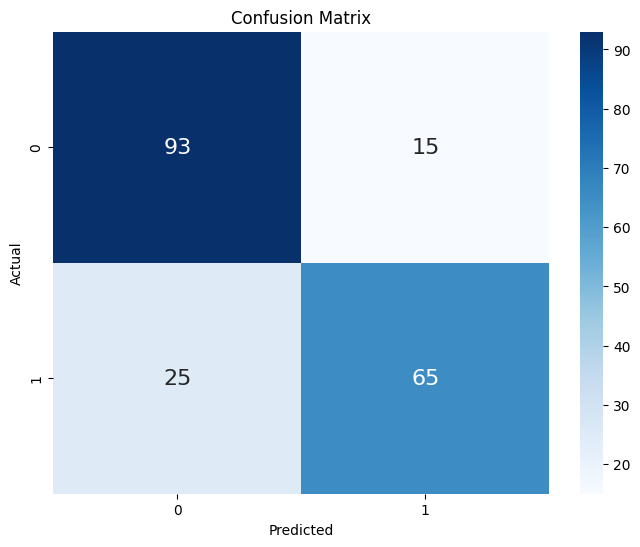


Classification Report:


In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
import seaborn as sns

y_pred = (model.predict(np.array(test_data)) > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(np.array(test_labels), y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print('\nClassification Report:')


In [18]:
model.save("model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
model = tf.keras.models.load_model('model.h5')

In [20]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       108
           1       0.81      0.72      0.76        90

    accuracy                           0.80       198
   macro avg       0.80      0.79      0.79       198
weighted avg       0.80      0.80      0.80       198



In [ ]:
test_video_path = "/kaggle/input/car-thief/Moment thieves use hi-tech device to steal 25000 keyless BMW.mp4"

In [17]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)